#### Estimación de la edad de la persona sobre el dataset UTK. Usaremos un modelo de regresión, partiendo de la red Mobilenetpara intentar determinar la edad de una persona a partir de una imagen de la cara de la misma. 

#### Importamos las bibliotecas necesarias

In [1]:
#! pip install mlxtend
#! pip install plot_keras_history
import os
import random
import shutil
import numpy as np
import tensorflow as tf
import cv2
from sklearn.metrics import confusion_matrix, classification_report

from mlxtend.plotting import plot_confusion_matrix

from matplotlib import pyplot as plt
#from tensorflow.keras.metrics import Precision, Recall, Accuracy

# Importamos algunas dependencias fundamentales de la API de tensorflow
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten, BatchNormalization, Dropout, LeakyReLU
import tensorflow as tf

from tensorflow.keras.losses import BinaryCrossentropy

from tensorflow.keras.optimizers import SGD, Adam

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from plot_keras_history import plot_history


from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error

#El modelo usado en esta ocasión será Mobilenet
from keras.applications.mobilenet import MobileNet


#from tensorflow.keras.applications import EfficientNetV2B3

from sklearn.model_selection import StratifiedShuffleSplit #No pude hacer una división estratificada por haber pocas personas con ciertas edades

import shutil

2025-05-31 18:39:36.719818: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


#### Definimos las rutas del dataset completo y analizamos el número de imágenes

In [2]:
ruta_actual = os.getcwd()
ruta_dataset = os.path.join(ruta_actual,"UTKFace")

numero_imagenes_total = len(os.listdir(ruta_dataset))

numero_imagenes_validacion = round(10*numero_imagenes_total/100)
numero_imagenes_test = numero_imagenes_validacion
numero_imagenes_entrenamiento = numero_imagenes_total - 2*numero_imagenes_validacion

print(f"Número de imágenes total: {numero_imagenes_total}")

print(f"Número de imágenes en entrenamiento: {numero_imagenes_entrenamiento}")
print(f"Número de imágenes en validación: {numero_imagenes_validacion}")
print(f"Número de imágenes en test: {numero_imagenes_test}")

#Un 10% de imágenes para validación y test parece adecuado


Número de imágenes total: 23708
Número de imágenes en entrenamiento: 18966
Número de imágenes en validación: 2371
Número de imágenes en test: 2371


#### Estudiamos el dataset para la característica edad

##### Creamos un directorio de nombre edad para almacenar los datasets relativos a la edad. A su vez dentro de este directorio creamos carpetas de nombres entrenamiento, validacion y test las cuales contendrán en su interior la división del dataset.

In [3]:
#Creamos la carpeta edad si no existe
ruta_edad = os.path.join(ruta_actual,"edad")
try:
    os.mkdir(ruta_edad)
except:
    print("La carpeta edad ya había sido creada previamente")

#Creamos la carpeta entrenamiento dentro de la carpeta edad
ruta_entrenamiento_edad = os.path.join(ruta_edad,"entrenamiento")
try:
    os.mkdir(ruta_entrenamiento_edad)
except:
    print("La carpeta entrenamiento dentro de la carpeta edad ya fue creada previamente")


#Creamos la carpeta validacion dentro de la carpeta edad
ruta_validacion_edad = os.path.join(ruta_edad,"validacion")
try:
    os.mkdir(ruta_validacion_edad)
except:
    print("La carpeta validacion dentro de la carpeta edad ya fue creada previamente")

#Creamos la carpeta test dentro de la carpeta edad
ruta_test_edad = os.path.join(ruta_edad,"test")
try:
    os.mkdir(ruta_test_edad)
except:
    print("La carpeta test dentro de la carpeta edad ya fue creada previamente")


#### Contamos el número de personas para cada edad

In [4]:
edades =[0] * 116

lista_nombres = os.listdir(ruta_dataset)

for nombre in lista_nombres:
    edad = nombre.split("_")[0]
    edad = int(edad)

    edades[edad-1]+=1    

for edad,numero in enumerate(edades):
    print(f"Existen {numero} personas con {edad+1} años en el dataset")
    

Existen 1123 personas con 1 años en el dataset
Existen 482 personas con 2 años en el dataset
Existen 289 personas con 3 años en el dataset
Existen 273 personas con 4 años en el dataset
Existen 196 personas con 5 años en el dataset
Existen 131 personas con 6 años en el dataset
Existen 139 personas con 7 años en el dataset
Existen 263 personas con 8 años en el dataset
Existen 166 personas con 9 años en el dataset
Existen 156 personas con 10 años en el dataset
Existen 65 personas con 11 años en el dataset
Existen 130 personas con 12 años en el dataset
Existen 81 personas con 13 años en el dataset
Existen 157 personas con 14 años en el dataset
Existen 177 personas con 15 años en el dataset
Existen 247 personas con 16 años en el dataset
Existen 158 personas con 17 años en el dataset
Existen 262 personas con 18 años en el dataset
Existen 98 personas con 19 años en el dataset
Existen 284 personas con 20 años en el dataset
Existen 346 personas con 21 años en el dataset
Existen 395 personas con

#### Se observa que no hay personas de todas las edades entre 1 y 116 años. Dividimos el dataset en carpetas entrenamiento, validación y test. Se separa el dataset en entrenamiento, validación y test (No se hace una división estratificada porque no hay personas de todas las edades)

In [5]:
#Realizamos la primer división para obtener el conjunto de entrenamiento 
imagenes_entrenamiento, imagenes_temp = train_test_split(lista_nombres, test_size=0.2, random_state=42)

#Dividimos el resto del conjunto en validación y test
imagenes_validacion, imagenes_test = train_test_split(imagenes_temp, test_size=0.5, random_state=42)

#Guardamos las imágenes en los directorios correspondientes:

#imágenes entrenamiento
for imagen in imagenes_entrenamiento:
    ruta_imagen = os.path.join(ruta_dataset,imagen)
    shutil.copy(ruta_imagen,ruta_entrenamiento_edad)

#imágenes de validación
for imagen in imagenes_validacion:
    ruta_imagen = os.path.join(ruta_dataset,imagen)
    shutil.copy(ruta_imagen,ruta_validacion_edad)    

#imágenes de test    
for imagen in imagenes_test:
    ruta_imagen = os.path.join(ruta_dataset,imagen)
    shutil.copy(ruta_imagen,ruta_test_edad)


#### Creamos los datasets usando la api tf.data.Dataset

In [6]:
#Las imágenes tienen tamaños reales de 200 píxeles x 200 píxeles
alto = 224
ancho = 224

#Elegimos el tamaño de lote como 64:
tamano_lote = 64

#Definimos funciones para preprocesar las imágenes a partir de la ruta
def cargar_preprocesar_imagen(ruta):
    parts = tf.strings.split(ruta, os.path.sep)
    nombre_imagen = parts[-1]

    #Las siguientes líneas dan error y tuvieron que ser cambiadas
    #edad = float(nombre_imagen.split("_")[0])
    #etiqueta = tf.constant(edad,dtype=tf.float32)
    
    #Usar tf.strings.split y tf.strings.to_number para extraer y convertir la edad
    edad_cadena = tf.strings.split(nombre_imagen, sep="_")[0]
    edad = tf.strings.to_number(edad_cadena, out_type=tf.float32)
    
    
    imagen = tf.io.read_file(ruta)
    imagen = tf.image.decode_jpeg(imagen, channels=3)
    imagen = tf.image.resize(imagen, [alto, ancho])
    imagen = imagen / 255.0  # Normalizar a [0, 1]
    return imagen, edad

# Función de envoltura para tf.py_function
def cargar_preprocesar_imagen_con_etiqueta(ruta):
    imagen, etiqueta = tf.py_function(cargar_preprocesar_imagen, [ruta], [tf.float32, tf.float32])
    imagen.set_shape((alto, ancho, 3))  # Asegurar que la imagen tenga la forma correcta
    etiqueta.set_shape(())  # La etiqueta es un escalar
    #etiqueta = tf.one_hot(etiqueta, 2)  # Convertir la etiqueta a one-hot encoding
    return imagen, etiqueta


######## DATASET ENTRENAMIENTO ############
# Cargamos las imágenes desde el directorio de entrenamiento. Las imágenes son preprocesadas y preparadas para entrenar la red.
dataset_entrenamiento = tf.data.Dataset.list_files(ruta_entrenamiento_edad + '/*.jpg')
dataset_entrenamiento = dataset_entrenamiento.map(cargar_preprocesar_imagen_con_etiqueta, num_parallel_calls=tf.data.AUTOTUNE)
#No hemos definido una función para hacer data augmentation (En principio no haremos data augmentation)
#dataset_entrenamiento = dataset_entrenamiento.map(aumento_imagenes, num_parallel_calls=tf.data.AUTOTUNE)

#barajamos el dataset
dataset_entrenamiento = dataset_entrenamiento.shuffle(buffer_size=1000)
#Hacemos los lotes del dataset del tamaño especificado
dataset_entrenamiento = dataset_entrenamiento.batch(tamano_lote)
dataset_entrenamiento = dataset_entrenamiento.prefetch(buffer_size=tf.data.AUTOTUNE)
dataset_entrenamiento = dataset_entrenamiento.repeat()  # Añadir repeat() para que se itere sobre el dataset una vez que se acaben los bastches


######## DATASET VALIDACIÓN ############
# Cargamos las imágenes desde el directorio de validación. Las imágenes son preprocesadas y preparadas para validar la red.
dataset_validacion = tf.data.Dataset.list_files(ruta_validacion_edad + '/*.jpg')

#Preprocesamos las imágenes
dataset_validacion = dataset_validacion.map(cargar_preprocesar_imagen_con_etiqueta, num_parallel_calls=tf.data.AUTOTUNE)
#No necesitamos barajar el dataset de validación
#dataset_validacion = dataset_validacion.shuffle(buffer_size=100)
#dataset_validacion = dataset_validacion.cache() #No se debe usar (nos quedamos sin ram) 

#Hacemos los lotes del dataset del tamaño especificado
dataset_validacion = dataset_validacion.batch(tamano_lote)
dataset_validacion = dataset_validacion.prefetch(buffer_size=tf.data.AUTOTUNE)
dataset_validacion = dataset_validacion.repeat()



######## DATASET TEST ############
# Cargar las imágenes desde el directorio de test. Si se desean entrenar otros modelos, se usarán estas imágenes para ver cual de ellos es el mejor
dataset_test = tf.data.Dataset.list_files(ruta_test_edad + '/*.jpg')
dataset_test = dataset_test.map(cargar_preprocesar_imagen_con_etiqueta, num_parallel_calls=tf.data.AUTOTUNE)
#dataset_test = dataset_test.cache() #Nos quedamos sin ram si activamos esta opción
dataset_test = dataset_test.batch(tamano_lote)
dataset_test = dataset_test.prefetch(buffer_size=tf.data.AUTOTUNE)
dataset_test = dataset_test.repeat()

######## IMÁGENES DE CADA CONJUNTO ############
# Número de imágenes en el conjunto de entrenamiento, validación Y test
numero_imagenes_entrenamiento = len(os.listdir(ruta_entrenamiento_edad))
numero_imagenes_validacion = len(os.listdir(ruta_validacion_edad))
numero_imagenes_test = len(os.listdir(ruta_test_edad))


2025-05-31 18:39:38.544195: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-05-31 18:39:38.620722: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-05-31 18:39:38.620851: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-05-31 18:39:38.622286: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compi

In [7]:
print(f"Número de imágenes para entrenamiento: {numero_imagenes_entrenamiento}")
print(f"Número de imágenes para validación: {numero_imagenes_validacion}")
print(f"Número de imágenes para test: {numero_imagenes_test}")

Número de imágenes para entrenamiento: 18966
Número de imágenes para validación: 2371
Número de imágenes para test: 2371


#### Definimos la arquitectura del modelo, usando como base el modelo MobileNet

In [8]:
def mobileNet_edad(alto_imagen = alto, ancho_imagen = ancho):
  #Definimos el tensor (imagen) de entrada en 3 canales
  tensor_entrada = Input(shape=(alto_imagen, ancho_imagen, 3))

  #Instanciamos la arquitectura de la red MobilNet
  mobileNet_edad = MobileNet(input_tensor = tensor_entrada, include_top=False, weights = "imagenet")

  ultima_capa = mobileNet_edad.layers[-1].output
  x= Flatten(name='flatten')(ultima_capa)
  x = Dense(64, activation='relu', name='fc1')(x)
  x = Dense(32, activation='relu', name='fc2')(x)
  salida = Dense(1, activation='linear', name='edad')(x)
  modelo_edad = Model(tensor_entrada, salida)

  #Congelamos los pesos de la capa convolucional (mantenemos los de la red MobileNet que fueron entrenados sobre ImageNet)
  #for capa in modelo_edad.layers[:-4]:
	#  capa.trainable = False

  return modelo_edad

In [9]:
#Vemos la arquitectura de la red que estima la edad
modelo = mobileNet_edad()
modelo.summary()
#No tenemos muchos datos, pero el modelo es bastante grande

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                                      

#### Definimos el optimizador, función de pérdida, early stopping y disminución de learning rate si no mejora el entrenamiento. También realizamos la compilación del modelo.

##### Definimos la tasa de aprendizaje y el optimizador deseado (Adam)

In [10]:
tasa_aprendizaje = 0.0001 
optimizador =  Adam(learning_rate = tasa_aprendizaje)

##### Definimos parada temprana (EarlyStopping)

In [11]:
# Early stopping
parada_temprana = EarlyStopping(monitor='val_loss', patience=12, restore_best_weights=True)

##### Definimos la caida del learning rate si el val_loss no mejora tras 5 épocas

In [12]:
# Reduce Learning rate on Plateau
reducir_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-6)


#### Compilamos el modelo

In [13]:
modelo.compile(optimizer=optimizador,loss = 'mse', metrics=["mae"] )

#### Calculamos los pasos de entrenamiento, de validación y del test del modelo

In [14]:
if numero_imagenes_entrenamiento % tamano_lote == 0:
    pasos_entrenamiento = numero_imagenes_entrenamiento // tamano_lote
else:
    pasos_entrenamiento = numero_imagenes_entrenamiento // tamano_lote +1

if numero_imagenes_validacion % tamano_lote == 0:
    pasos_validacion = numero_imagenes_validacion // tamano_lote
else:
    pasos_validacion = numero_imagenes_validacion // tamano_lote +1

if numero_imagenes_test % tamano_lote == 0:
    pasos_test = numero_imagenes_test // tamano_lote
else:
    pasos_test = numero_imagenes_test // tamano_lote +1


print(f"Número de pasos de entrenamiento para un batch size de {tamano_lote}: {pasos_entrenamiento}")
print(f"Número de pasos de validación para un batch size de {tamano_lote}: {pasos_validacion}")
print(f"Número de pasos de test para un batch size de para un batch size de {tamano_lote}: {pasos_test}")

Número de pasos de entrenamiento para un batch size de 64: 297
Número de pasos de validación para un batch size de 64: 38
Número de pasos de test para un batch size de para un batch size de 64: 38


#### Entrenamos por 100 épocas la red. El entrenamiento parará antes a causa del early stopping

In [15]:
# Entrenamiento del modelo
numero_epocas = 100

historia = modelo.fit(
    dataset_entrenamiento,
    epochs=numero_epocas,
    validation_data=dataset_validacion,
    steps_per_epoch=pasos_entrenamiento,
    validation_steps=pasos_validacion,
    callbacks=[parada_temprana, reducir_lr]
)

Epoch 1/100


2025-05-31 18:39:46.373403: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8204
2025-05-31 18:39:47.575812: W tensorflow/stream_executor/gpu/asm_compiler.cc:230] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.9
2025-05-31 18:39:47.575832: W tensorflow/stream_executor/gpu/asm_compiler.cc:233] Used ptxas at ptxas
2025-05-31 18:39:47.575947: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2025-05-31 18:39:48.990460: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


297/297 [==============================] - 177s 563ms/step - loss: 156.8121 - mae: 8.7782 - val_loss: 96.0437 - val_mae: 7.8576 - lr: 1.0000e-04
Epoch 2/100
297/297 [==============================] - 171s 559ms/step - loss: 55.2590 - mae: 5.5194 - val_loss: 69.8641 - val_mae: 6.1511 - lr: 1.0000e-04
Epoch 3/100
297/297 [==============================] - 170s 556ms/step - loss: 32.7273 - mae: 4.3216 - val_loss: 64.3576 - val_mae: 5.9256 - lr: 1.0000e-04
Epoch 4/100
297/297 [==============================] - 169s 555ms/step - loss: 18.5760 - mae: 3.2677 - val_loss: 66.8823 - val_mae: 5.8876 - lr: 1.0000e-04
Epoch 5/100
297/297 [==============================] - 169s 554ms/step - loss: 13.0674 - mae: 2.7140 - val_loss: 61.0756 - val_mae: 5.7519 - lr: 1.0000e-04
Epoch 6/100
297/297 [==============================] - 170s 557ms/step - loss: 10.5360 - mae: 2.4138 - val_loss: 72.4117 - val_mae: 6.1312 - lr: 1.0000e-04
Epoch 7/100
297/297 [==============================] - 169s 554ms/step - lo

#### Guardamos los pesos de la red entrenada

In [16]:
modelo.save("modelo_edad.h5")

#### Podemos cargar los pesos del modelo

In [17]:
modelo_cargado = load_model("modelo_edad.h5")

### Analizamos los resultado en historia

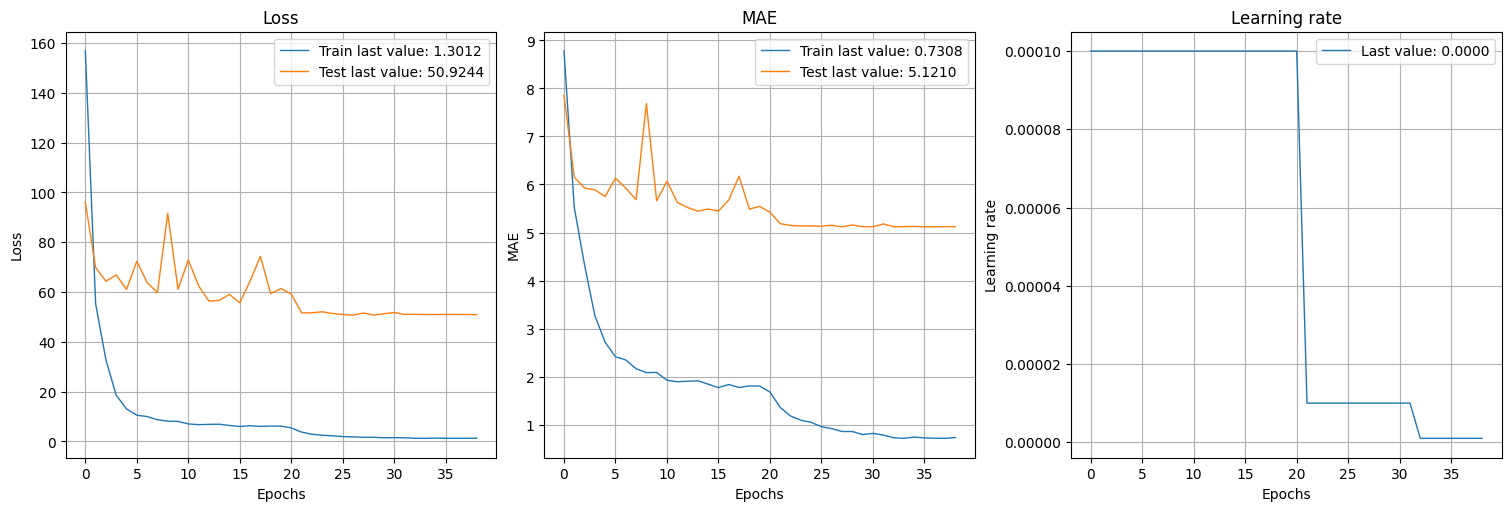

In [18]:
#Mostramos gráficas de interes del entrenamiento en función de las épocas

#from plot_keras_history import plot_history
plot_history(historia)
plt.show()

#### Calculamos el MAE y el MSE sobre el conjunto de entrenamiento, validación y test.

#### Definimos una función para calcular MAE y MSE sobre un dataset

In [19]:
def calculo_mae_mse(dataset, pasos):
    predicciones = np.array([])
    etiquetas = np.array([])

    generador = dataset.take(pasos).as_numpy_iterator()

    for _ in range(pasos):
        imagenes, labels = next(generador)

        # Predecimos y aplanamos la salida
        prediccion_lote = modelo_cargado.predict(imagenes, verbose=0).flatten()
        labels = labels.flatten()  

        predicciones = np.concatenate((predicciones, prediccion_lote), axis=0)
        etiquetas = np.concatenate((etiquetas, labels), axis=0)

    mae = mean_absolute_error(etiquetas, predicciones)
    mse = mean_squared_error(etiquetas, predicciones)

    return mae, mse


#### MAE y MSE entrenamiento

In [20]:
mae_entrenamiento, mse_entrenamiento = calculo_mae_mse(dataset_entrenamiento,pasos_entrenamiento)
print(f"El mae en el conjunto de entrenamiento es {mae_entrenamiento}")
print(f"El mse en el conjunto de entrenamiento es {mse_entrenamiento}")

El mae en el conjunto de entrenamiento es 0.7146994964390809
El mse en el conjunto de entrenamiento es 1.2722853915814387


#### MAE y MSE validación

In [21]:
mae_validacion, mse_validacion = calculo_mae_mse(dataset_validacion,pasos_validacion)
print(f"El mae en el conjunto de validación es {mae_validacion}")
print(f"El mse en el conjunto de validación es {mse_validacion}")

El mae en el conjunto de validación es 5.15165935954977
El mse en el conjunto de validación es 50.70990030316475


#### MAE y MSE test

In [22]:
mae_test, mse_test = calculo_mae_mse(dataset_test,pasos_test)
print(f"El mae en el conjunto de test es {mae_test}")
print(f"El mse en el conjunto de test es {mse_test}")

El mae en el conjunto de test es 5.197212442589938
El mse en el conjunto de test es 53.04360380780795


##### Aproximamos la predicción del modelo y calculamos una especie de accuracy sobre los conjuntos de entrenamiento, validación y test.

In [23]:
def calculo_accuracy(dataset,pasos):
    #Creamos arrays vacíos
    prediccion = np.array([])
    etiquetas = np.array([])

    generador = dataset.take(pasos).as_numpy_iterator()

    for iteracion in range(pasos):
        lote = generador.next()
        imagenes = lote[0]
        labels = lote[1]
    
        #Calculamos la prediccion del modelo sobre el batch
        prediccion_lote = modelo_cargado.predict(imagenes)
        prediccion_lote = np.round(prediccion_lote.reshape(1,-1).flatten())
        prediccion = np.concatenate((prediccion, prediccion_lote), axis=0)
        etiquetas = np.concatenate((etiquetas, labels), axis=0)
        
    #Devolvemos el accuracy con los redondeos realizados sobre las predicciones

    return accuracy_score(prediccion,etiquetas)

###### Cálculos sobre el conjunto de entrenamiento

In [24]:
accuracy_entrenamiento = calculo_accuracy(dataset_entrenamiento,pasos_entrenamiento)

1/1 [==============================] - 0s 13ms/step


In [25]:
print(f"El accuracy sobre el conjunto de entrenamiento es {accuracy_entrenamiento}")

El accuracy sobre el conjunto de entrenamiento es 0.4873985025835706


###### Cálculos sobre el conjunto de validación

In [26]:
accuracy_validacion = calculo_accuracy(dataset_validacion,pasos_validacion)

1/1 [==============================] - 0s 11ms/step


In [27]:
print(f"El accuracy sobre el conjunto de validacion es {accuracy_validacion}")

El accuracy sobre el conjunto de validacion es 0.08688317165752847


###### Cálculos sobre el conjunto de test

In [28]:
accuracy_test = calculo_accuracy(dataset_test,pasos_test)

1/1 [==============================] - 0s 10ms/step


In [29]:
print(f"El accuracy sobre el conjunto de entrenamiento es {accuracy_test}")

El accuracy sobre el conjunto de entrenamiento es 0.09995782370307887


#### Mostramos imágenes del conjunto de test, el valor real de la edad y la predicción del modelo

#### Definimos una función para mostrar ejemplos con la edad real y con la predicción de edad del modelo

In [30]:
def mostrar_predicciones(dataset, cantidad=16):
    # Tomamos un único lote de imágenes
    imagenes, etiquetas = next(iter(dataset))

    # Nos aseguramos que hay suficientes imágenes en el lote que hemos tomado
    imagenes = imagenes[:cantidad]
    etiquetas = etiquetas[:cantidad].numpy().flatten()

    # Predecimos
    predicciones = modelo_cargado.predict(imagenes, verbose=0).flatten()

    # Mostrar
    plt.figure(figsize=(15, 10))
    for i in range(cantidad):
        plt.subplot(4, 4, i + 1)
        plt.imshow(imagenes[i])
        plt.axis('off')
        plt.title(f"Real: {int(etiquetas[i])} | Pred: {int(predicciones[i])}")

    plt.tight_layout()
    plt.show()

#### Mostramos ejemplos de 16 imágenes con la edad real y la predicción del modelo

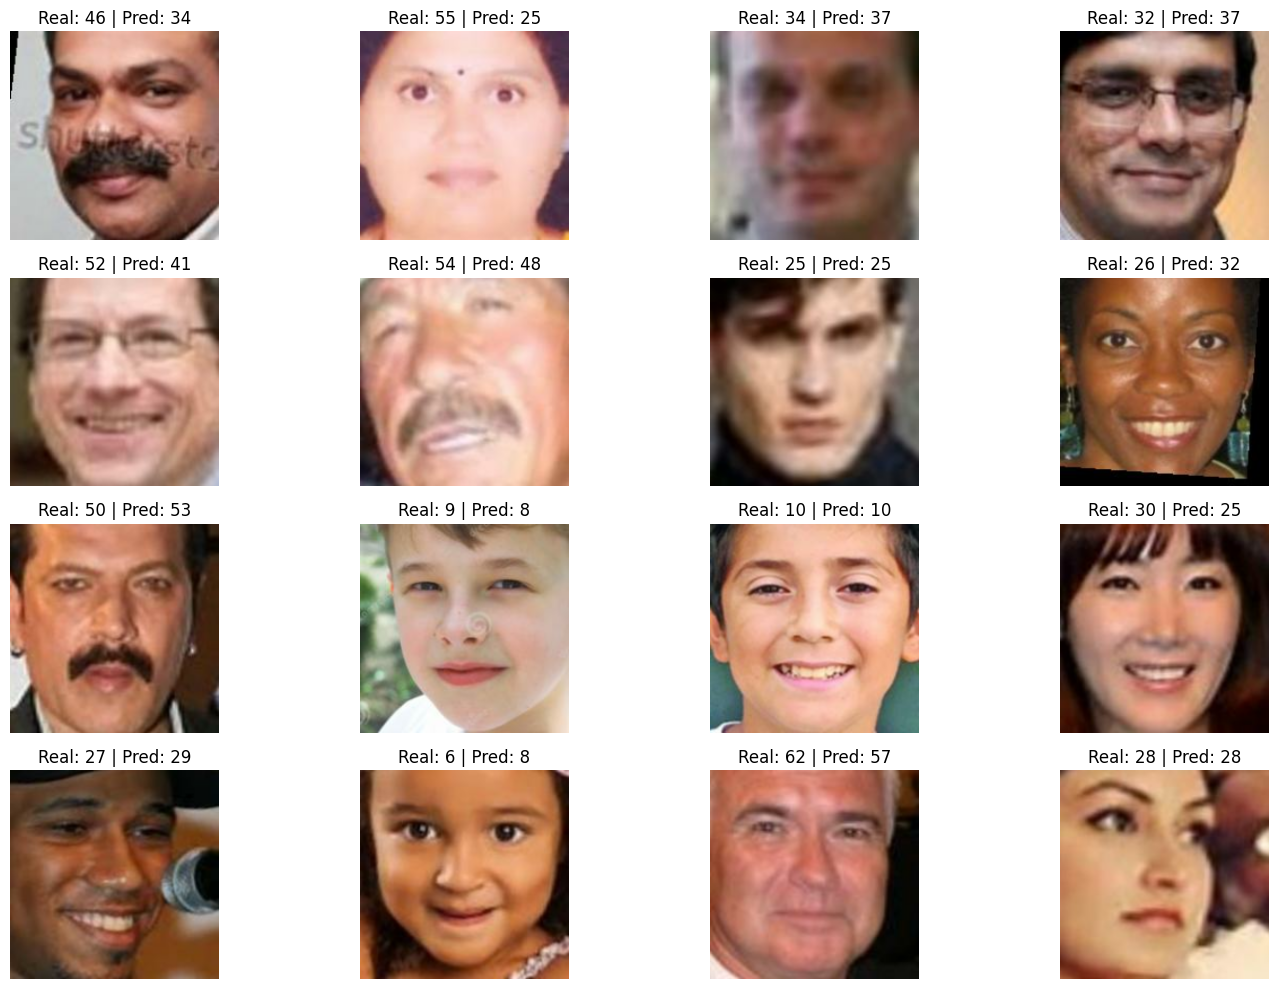

In [31]:
mostrar_predicciones(dataset_test,cantidad=16)